# Importing required modules

In [1]:
import os # to interact with the file system
import shutil # to copy and remove files
import numpy as np # for mathematical and logical operations on arrays
import glob # to retrieve files/pathnames matcing a specific pattern
import matplotlib.pyplot as plt # for plotting 2d images of data
from keras.layers import Input, Dense, Flatten,Dropout,GlobalAveragePooling2D # for model
from keras.models import Model # groups layers into an object with training and inference features
from keras.preprocessing import image # set of tools for real-time data augmentation on image data
from keras.applications.imagenet_utils import preprocess_input # for imagenet data preprocessing 
from keras.preprocessing.image import ImageDataGenerator # generate batches of tensor image data with real-time data augmentation
from keras.applications import ResNet50 # for importing the  pretrained model
from keras.applications.resnet50 import preprocess_input # to make the images to the required format
from keras.models import Sequential # to import sequential model
import cv2 # for image processing [computer vision]
import seaborn as sb # to plot data

# Plotting the data

In [2]:
data="../input/flowers-recognition/flowers/flowers"
flower_categories=['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
features=[]
for i in flower_categories:
    path=os.path.join(data,i)
    number_classes=flower_categories.index(i)
    for image in os.listdir(path):
        if image.endswith('.jpg'):
            image_array=cv2.imread(os.path.join(path,image),cv2.IMREAD_COLOR)
            image_array=cv2.resize(image_array,(150,150))
            features.append([image_array,number_classes])

In [3]:
# SEPERATING THE DATA AS EXPLANATORY VARIABLES AND RESPONSE VARIABLES

X=[]   # explanatory variables
y=[]   # response variable
for i,j in features:
    X.append(i)
    y.append(j)

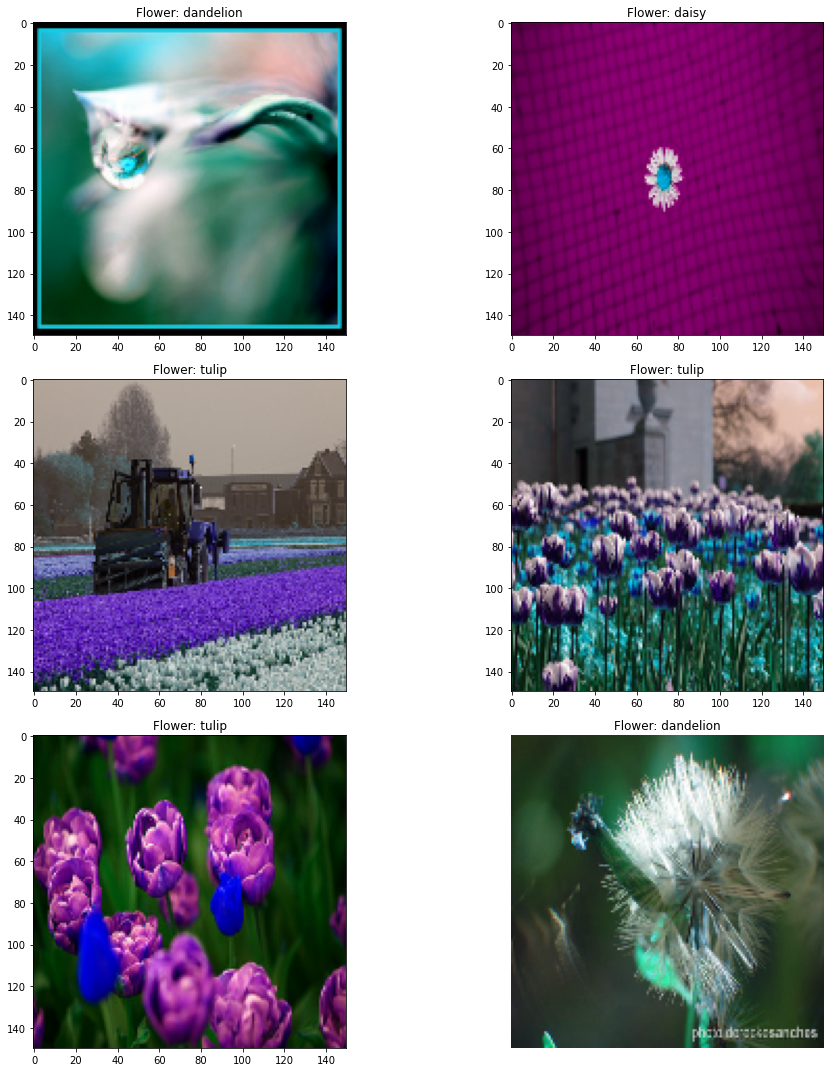

In [4]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=np.random.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+flower_categories[y[l]])
plt.axis('off')        
plt.tight_layout()

# Plotting data distribution

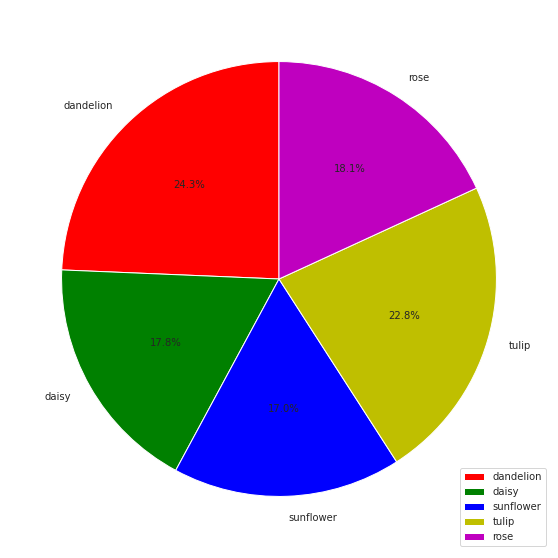

In [5]:
dandelion=len([i for i in y if i==0])
daisy=len([i for i in y if i==1])
sunflower=len([i for i in y if i==2])
tulip=len([ i for i in y if i==3])
rose=len([i for i in y if i==4])

species=[dandelion,daisy,sunflower,tulip,rose]

sb.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.pie(species,labels=flower_categories,startangle=90,colors=['r','g','b','y','m'],
        autopct='%1.1f%%')
plt.legend()
plt.show()

In [6]:
data = '../input/flowers-recognition/flowers'
# Training data dir
training_data = './Train'

# Test data dir
testing_data = './Test'

# Ratio of training and testing data
train_test_ratio = 0.8


def split_dataset_into_test_and_train_sets(all_data = data, 
                                           training_dir = training_data, 
                                           testing_dir=testing_data, 
                                           train_test_ratio = 0.8):
     # recreate test and train directories if they don't exist
    if not os.path.exists(training_dir):
        os.mkdir(training_dir)

    if not os.path.exists(testing_dir):
        os.mkdir(testing_dir)               
    
    num_training_files = 0
    num_testing_files = 0

    # iterate through the data directory 
    for subdir, dirs, files in os.walk(all_data):
        
        category_name = os.path.basename(subdir)

        if category_name == os.path.basename(all_data):
            continue

        training_data_category_dir = training_dir + '/' + category_name
        testing_data_category_dir = testing_dir + '/' + category_name
        
        # creating subdirectory for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(subdir + '/*.jpg')

        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]
        
        for lists in train_list : 
            shutil.copy(lists, training_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list :
            shutil.copy(lists, testing_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")
        

In [7]:
# split into train and test directories
split_dataset_into_test_and_train_sets()

dandelion has 1055 images
daisy has 769 images
dandelion has 1055 images
daisy has 769 images
sunflower has 734 images
tulip has 984 images
rose has 784 images
sunflower has 734 images
tulip has 984 images
rose has 784 images
Processed 6916 training files.
Processed 1730 testing files.


In [8]:
num_flower_category = 5
# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False)
    
# freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False
        
# Get the output from the base model 
base_model_ouput = base_model.output
    
# Adding our own layers at the end
# global average pooling: computes the average of all values in the feature map
x = GlobalAveragePooling2D()(base_model_ouput)
    
# fully connected and 5-softmax layer
x = Dense(512, activation='relu')(x)
x = Dense(num_flower_category, activation='softmax', name='fcnew')(x)
    
model = Model(inputs=base_model.input, outputs=x)

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
# help(ImageDataGenerator)
train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)

# do only basic preprocessing for validation data (no data augmentation)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

# create data generator objects
train_generator = train_data_gen.flow_from_directory(training_data, 
                                                     (224,224), 
                                                     batch_size=64, 
                                                     class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_data, 
                                                     (224,224), 
                                                     batch_size=64, 
                                                     class_mode='categorical')

Found 4148 images belonging to 5 classes.
Found 1555 images belonging to 5 classes.


In [11]:
# Training the newly added layers 
# flow data (in batches) from directories (while simultaneously preprocessing/augmenting
batch_size=64
epochs=10
r = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//batch_size,
                    epochs=epochs,
                    verbose=1)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
64/64 [==============================] - 615s 10s/step - loss: 0.9435 - accuracy: 0.6490 - val_loss: 0.4055 - val_accuracy: 0.8776
Epoch 2/10
64/64 [==============================] - 598s 9s/step - loss: 0.3901 - accuracy: 0.8784 - val_loss: 0.3173 - val_accuracy: 0.9030
Epoch 3/10
64/64 [==============================] - 591s 9s/step - loss: 0.3531 - accuracy: 0.8734 - val_loss: 0.2778 - val_accuracy: 0.9128
Epoch 4/10
64/64 [==============================] - 606s 9s/step - loss: 0.2975 - accuracy: 0.9038 - val_loss: 0.2512 - val_accuracy: 0.9167
Epoch 5/10
64/64 [==============================] - 581s 9s/step - loss: 0.2871 - accuracy: 0.9031 - val_loss: 0.2321 - val_accuracy: 0.9238
Epoch 6/10
64/64 [==============================] - 584s 9s/step - loss: 0.2490 - accuracy: 0.9177 - val_loss: 0.2311 - val_accuracy: 0.9251
Epoch 7/10
64/64 [==============================] - 583s 9s/step - loss: 0.2507 - accuracy: 0.9146 - val_loss: 0.2098 - val_accuracy: 0.9323
Epoch 8/10
6

# Plotting loss

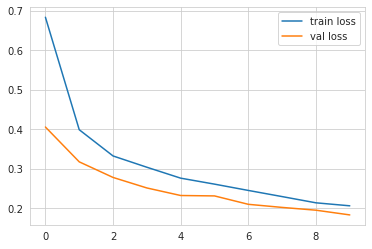

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plotting accuracy

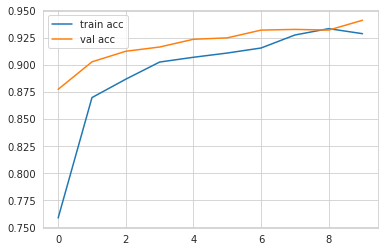

<Figure size 432x288 with 0 Axes>

In [13]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Evaluating predictions

In [14]:
y_pred=model.predict(valid_generator)

In [15]:
y_final=[]
for i in range(len(y_pred)):
  y_final.append(np.argmax(y_pred[i]))
type(y_final[0])

numpy.int64